https://www.tensorflow.org/tutorials/images/transfer_learning

## Loading the data

In [16]:
import tensorflow as tf
# Path to data folders
root='CrackBinaryClassificationData/'
train_dir = root+'train/'
test_dir = root+'test/'

train_crack_dir = train_dir+'crack/'
train_nocrack_dir = train_dir+'no_crack/'

test_crack_dir = test_dir+'crack/'
test_nocrack_dir = test_dir+'no_crack/'
IMG_SIZE=(160,160) # Image size changed to be compatible with image net (also color mode below)
BATCH_SIZE=32

train_ds=tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    label_mode='binary',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
)

test_ds=tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    label_mode='binary',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
)

Found 1204 files belonging to 2 classes.
Found 284 files belonging to 2 classes.


## Data augmentation

In [17]:
# Data augmentation
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.2),
        # tf.keras.layers.RandomRotation(0.3, fill_mode='reflect'),
        # tf.keras.layers.RandomTranslation(0.2,0.2, fill_mode='wrap')
    ]
)

augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

## Loading the pretrained model

In [18]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
# Freeze the base model to prevent changing the weights when tuning 
base_model.trainable = False


In [19]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_7[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

The base model (with its final classification layer removed: include_top=False) transforms 3 channel 160 by 160 images into 5 by 5 by 1280 features

In [20]:
# Rescale in the format expected by mobilenet (pixel range between -1 and 1)
# This will go before the base_model
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input
# Add trainable layers that will learn to classify our examples
# This will go after the base_model
# The tutorial uses GlobalAveragePooling to flatten the 5 by 5 by 1280 into a 1280 element vector
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# Now, we need a single prediction per layer, so similar to before we use a dense layer
prediction_layer = tf.keras.layers.Dense(1)

Now we build this composite model
I could not find a way to make the preprocess input function into a keras layer to work with sequential. Looks like I'd have to use the functional method: https://www.tensorflow.org/guide/keras/functional_api

In [21]:
preprocessed_train_ds = augmented_train_ds.map(
    lambda x, y: (preprocess_input(x), y))

preprocessed_test_ds = test_ds.map(
    lambda x, y: (preprocess_input(x), y))

In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(160, 160, 3)),
    base_model,
    global_average_layer,
    tf.keras.layers.Dropout(0.2),
    prediction_layer
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [39]:
history=model.fit(
  preprocessed_train_ds,
  validation_data=preprocessed_test_ds,
  epochs=20,
  shuffle=True
)

Epoch 1/20
38/38 [==============================] - 6s 161ms/step - loss: 0.4739 - accuracy: 0.7267 - val_loss: 0.4525 - val_accuracy: 0.7852
Epoch 2/20
38/38 [==============================] - 6s 159ms/step - loss: 0.4527 - accuracy: 0.7409 - val_loss: 0.4392 - val_accuracy: 0.7746
Epoch 3/20
38/38 [==============================] - 6s 159ms/step - loss: 0.4693 - accuracy: 0.7309 - val_loss: 0.4330 - val_accuracy: 0.7570
Epoch 4/20
38/38 [==============================] - 6s 161ms/step - loss: 0.4484 - accuracy: 0.7500 - val_loss: 0.4491 - val_accuracy: 0.7958
Epoch 5/20
38/38 [==============================] - 6s 159ms/step - loss: 0.4502 - accuracy: 0.7409 - val_loss: 0.4523 - val_accuracy: 0.7958
Epoch 6/20
38/38 [==============================] - 6s 159ms/step - loss: 0.4584 - accuracy: 0.7417 - val_loss: 0.4499 - val_accuracy: 0.7887
Epoch 7/20
38/38 [==============================] - 6s 157ms/step - loss: 0.4503 - accuracy: 0.7342 - val_loss: 0.4524 - val_accuracy: 0.7923
Epoch 

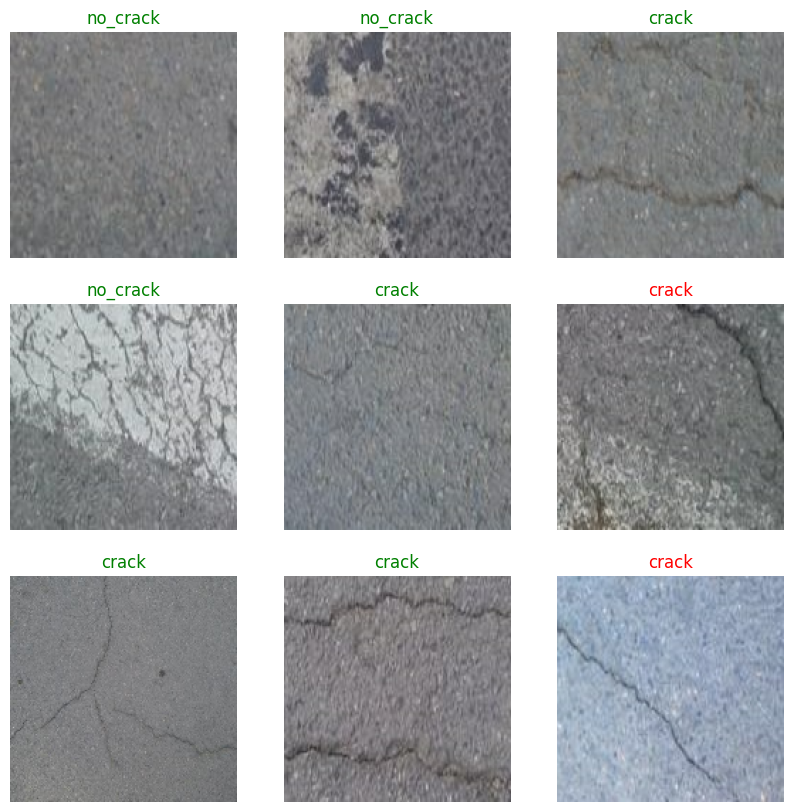

In [40]:
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

class_names=train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in preprocessed_test_ds.take(1):
  actuals=labels.numpy()
  pred_vals=model(images).numpy()
  # Apply a sigmoid since our model returns logits
  pred_vals = tf.nn.sigmoid(pred_vals)
  pred_vals = tf.where(pred_vals < 0.5, 0, 1)
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    act=class_names[int(actuals[i,0])]
    pred=class_names[round(pred_vals[i,0])]
    if act==pred:
      c='green'
    else:
      c='red'
    plt.title(act, fontdict={'color':c})
    plt.axis("off")